В домашньому завданні до даного модулю ви потренуєтесь робити тестове завдання для влаштування на роботу. За даними акселерометра з мобільного телефону потрібно класифікувати, якою діяльністю займається людина: йде, стоїть, біжить чи йде по сходах. Знайти датасет ви можете за посиланням.

Використайте алгоритми SVM та випадковий ліс з бібліотеки scikit-learn. Як характеристики можете брати показники з акселерометра, проте щоб покращити результати роботи алгоритмів, спочатку можна підготувати наш датасет і розрахувати часові ознаки (time domain features). Більше ці характеристики описані в даній статті.

Порівняйте результати роботи обох алгоритмів на різних фічах та різні моделі між собою.

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score

In [16]:
all_data = {'all_idle.csv':'idle', 'all_running.csv':'running', 'all_stairs.csv':'stairs', 'all_walking.csv':'walking'}
for i in all_data:
    df = pd.DataFrame(pd.read_csv(i))
    df['activity'] = all_data[i]
    df.to_csv(i, index=False)
    

In [15]:
df = pd.read_csv('all_data.csv')
df.head()

,accelerometer_X,accelerometer_Y,accelerometer_Z,activity
0,0.392649,-0.071826,9.768343,idle
1,0.387861,-0.062249,9.753978,idle
2,0.440533,0.033519,9.734824,idle
3,0.421380,-0.052672,9.749189,idle
4,0.426168,-0.019154,9.734824,idle


In [23]:
# Параметри для розділення на сегменти
segment_length = 100  # Задайте довжину сегменту вимірів (можете вибрати відповідний розмір)

# Розділити дані на сегменти для кожної активності
segments = []

for activity, group in df.groupby('activity'):
    activity_segments = [group.iloc[i:i+segment_length] for i in range(0, len(group), segment_length)]
    segments.extend(activity_segments)

# Розрахунок часових ознак для кожного сегмента
time_features_list = []

for segment in segments:
    time_diff = segment.index[-1] - segment.index[0]  # Обчислення часового інтервалу для сегмента
    time_diff_seconds = time_diff.total_seconds() if hasattr(time_diff, 'total_seconds') else 0
    mean_values = segment[['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']].mean()
    std_values = segment[['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']].std()
    max_values = segment[['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']].max()

    features = {
        'mean_accelerometer_X': mean_values['accelerometer_X'],
        'mean_accelerometer_Y': mean_values['accelerometer_Y'],
        'mean_accelerometer_Z': mean_values['accelerometer_Z'],
        'std_accelerometer_X': std_values['accelerometer_X'],
        'std_accelerometer_Y': std_values['accelerometer_Y'],
        'std_accelerometer_Z': std_values['accelerometer_Z'],
        'max_accelerometer_X': max_values['accelerometer_X'],
        'max_accelerometer_Y': max_values['accelerometer_Y'],
        'max_accelerometer_Z': max_values['accelerometer_Z'],
        'time_diff': time_diff_seconds  # Перетворення часового інтервалу в секунди
    }

    time_features_list.append(features)

# Створення DataFrame з часовими ознаками
time_features_df = pd.DataFrame(time_features_list)
time_features_df.to_csv('time_features.csv', index=False)

In [19]:
df = pd.read_csv('data_tdf.csv')
df.head()

,accelerometer_X,accelerometer_Y,accelerometer_Z,activity,mean_accelerometer_X,mean_accelerometer_Y,mean_accelerometer_Z,std_accelerometer_X,std_accelerometer_Y,std_accelerometer_Z,max_accelerometer_X,max_accelerometer_Y,max_accelerometer_Z
0,0.392649,-0.071826,9.768343,idle,0.401795,-0.027294,9.754026,0.051967,0.051991,0.019148,0.560243,0.086191,9.806650
1,0.387861,-0.062249,9.753978,idle,0.393990,-0.030933,9.758527,0.052331,0.051700,0.024028,0.560243,0.086191,9.821015
2,0.440533,0.033519,9.734824,idle,0.390542,-0.031651,9.758670,0.048644,0.049327,0.025456,0.560243,0.086191,9.821015
3,0.421380,-0.052672,9.749189,idle,0.243586,0.046256,9.762788,0.230532,0.123691,0.022270,0.560243,0.244209,9.821015
4,0.426168,-0.019154,9.734824,idle,0.392027,-0.025139,9.761639,0.040395,0.042445,0.023290,0.560243,0.086191,9.821015


In [21]:
# Розділяємо дані на features (ознаки) та labels (мітки)
features = df.drop('activity', axis=1)  # Всі колонки крім 'activity'
labels = df['activity']
print(features)

# Розділимо дані на тренувальний та тестовий набори
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=7)

# Нормалізуємо дані
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Модель SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

# Модель випадкового лісу
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Оцінка результатів за допомогою classification_report
svm_report = classification_report(y_test, svm_pred, zero_division=1)
rf_report = classification_report(y_test, rf_pred, zero_division=1)

print("Classification Report for SVM:\n", svm_report)
print("\nClassification Report for Random Forest:\n", rf_report)


        accelerometer_X  accelerometer_Y  accelerometer_Z  \
0              0.392649        -0.071826         9.768343   
1              0.387861        -0.062249         9.753978   
2              0.440533         0.033519         9.734824   
3              0.421380        -0.052672         9.749189   
4              0.426168        -0.019154         9.734824   
...                 ...              ...              ...   
193855         4.276045       -13.618219         0.172383   
193856         2.767697       -19.268536       -26.302700   
193857        -0.871489        -9.806650        -3.428497   
193858        -1.599327        -3.878607         3.246538   
193859        -5.152322        -9.255983        -1.230620   

        mean_accelerometer_X  mean_accelerometer_Y  mean_accelerometer_Z  \
0                   0.401795             -0.027294              9.754026   
1                   0.393990             -0.030933              9.758527   
2                   0.390542           

ValueError: Input X contains NaN.
SVC does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

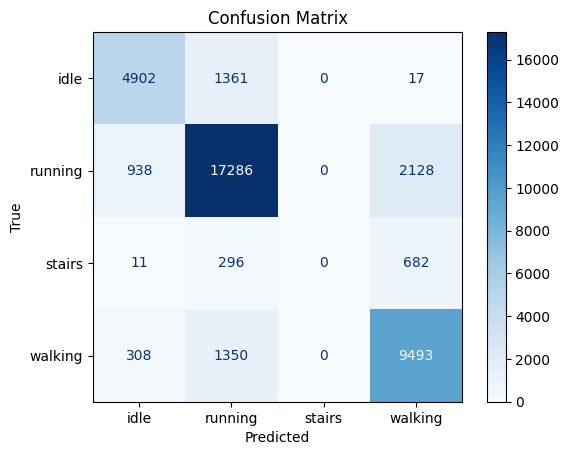

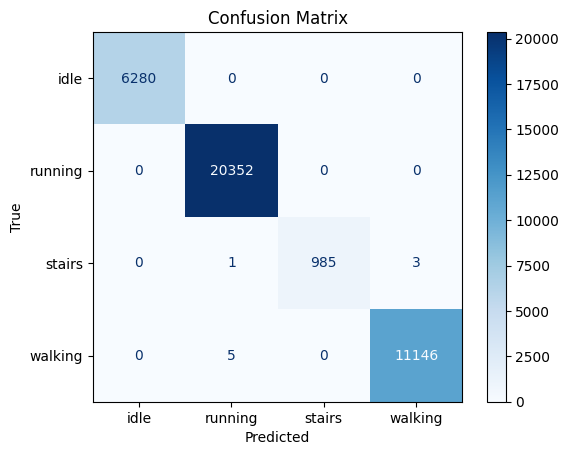

In [6]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Викликаємо функцію для SVM
plot_confusion_matrix(y_test, svm_pred, labels=svm_model.classes_)

# Викликаємо функцію для Random Forest
plot_confusion_matrix(y_test, rf_pred, labels=rf_model.classes_)

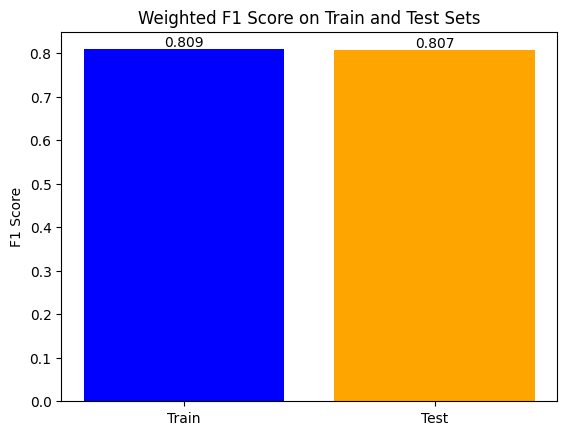

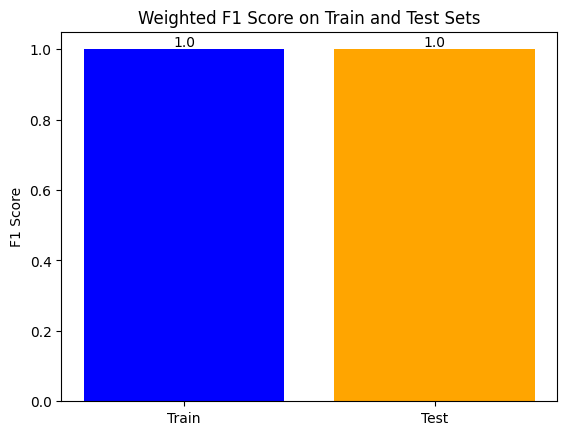

In [7]:
def plot_f1_scores(model, X_train, y_train, X_test, y_test):
    # Отримуємо прогнози для тренувального та тестового наборів
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    # Обчислюємо F1-скор для тренувального та тестового наборів
    train_f1 = f1_score(y_train, train_pred, average='weighted')
    test_f1 = f1_score(y_test, test_pred, average='weighted')

    # Побудова графіку
    labels = ['Train', 'Test']
    values = [train_f1, test_f1]

    fig, ax = plt.subplots()
    bars = ax.bar(labels, values, color=['blue', 'orange'])

    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')

    plt.title('Weighted F1 Score on Train and Test Sets')
    plt.ylabel('F1 Score')
    plt.show()

# Викликаємо функцію для SVM
plot_f1_scores(svm_model, X_train, y_train, X_test, y_test)

# Викликаємо функцію для Random Forest
plot_f1_scores(rf_model, X_train, y_train, X_test, y_test)